## 통합 데이터셋

In [24]:
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:,.0f}')
pd.set_option('display.max_columns', None)

# 데이터 로드
data_path = '../../data/training/preprocessing/final_traveler.csv'
df = pd.read_csv(data_path)
print('shape:', df.shape)

shape: (2560, 80)


In [25]:
# 필요없는 컬럼 삭제
cols = ['TRAVELER_ID', 'TRAVEL_NM', 'TRAVEL_PURPOSE', 'TRAVEL_PERSONA', 'activity_payment_count'
        , 'activity_store_count', 'activity_history_rows', 'activity_type_unique', 'lodging_payment_count', 'lodging_store_count'
        , 'RESIDENCE_SGG_CD', 'EDU_NM', 'TRAVEL_TERM', 'TRAVEL_NUM', 'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4'
        , 'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8', 'TRAVEL_STATUS_YMD'
        , 'TRAVEL_PURPOSE_22', 'TRAVEL_PURPOSE_1', 'TRAVEL_PURPOSE_6', 'TRAVEL_PURPOSE_4', 'TRAVEL_PURPOSE_2', 'TRAVEL_PURPOSE_26'
        , 'TRAVEL_PURPOSE_21', 'TRAVEL_PURPOSE_24', 'TRAVEL_PURPOSE_3', 'TRAVEL_PURPOSE_5', 'TRAVEL_PURPOSE_OTHER'
        , 'TRAVEL_PURPOSE_COUNT', 'TRAVEL_MISSION_CHECK_22', 'TRAVEL_MISSION_CHECK_1', 'TRAVEL_MISSION_CHECK_6'
        , 'TRAVEL_MISSION_CHECK_2', 'TRAVEL_MISSION_CHECK_21', 'TRAVEL_MISSION_CHECK_4', 'TRAVEL_MISSION_CHECK_24'
        , 'TRAVEL_MISSION_CHECK_3', 'TRAVEL_MISSION_CHECK_26', 'TRAVEL_MISSION_CHECK_5', 'TRAVEL_MISSION_CHECK_OTHER', 'TRAVEL_MISSION_CHECK_COUNT']

df = df.drop(columns = cols, axis = 1)

In [26]:
# # travel_mission, activity_type_code 추가
# 이름 통일(대문자)
# eda용으로 한글명 테이블도 혹은 변수이름매핑함수
# ---

# 1단계 각자 테이블에서 필요하다고 생각한 컬럼들 정제해서 만들었음(eda진행해서 만들 컬럼을 도출했음 >> 변수생성)
# 2단계 travel_id 기준 병합 
# 3단계 결측치와 이상치를 확인 -> 결측치는 아래 내용으로 전처리하기로 결정 / 이상치 
# - MVMN_NM 정보없음 대체
# - 코드 컬럼들은 전체 대비 비율이 너무 적은지 시각화해서 차이 보고 심하면 의미 비슷한거와 범위 합치기(단, 그 비율 적은게 강한 정보를 담고 있으면 냅두는게나음)
# 4단계 데이터 가공(TRAVEL ID 기준 컬럼계산해서 총소비금액 등등)
# - visit_dgstfn_avg / visit_revisit_avg / visit_rcmdin_avg 여행망함여부(타겟변수)생성
# 5단계 여기까진 된 데이터로 eda + 근데 타겟변수랑 시각화(seaborn만)는 봄

# 6단계 학습을 위한 데이터 준비
# 피처생성단계
# TRAVEL_START_YMD 월별컬럼, 계절컬럼
# travel_mission과 travel_mission_check 비교해서 실제로 하려고햇던 여행활동을 했는지 컬럼 생성 (y/n)
# lodging_payment_sum 숙박비합계컬럼 생성
# visit_rate 재방문여부에서 비율로 변경해서 컬럼생성

# 데이터 저장
# df.to_csv('../../data/training/preprocessing/final_prep_data.csv', encoding='utf-8-sig')

### 1단계: 기본 컬럼 정리와 날짜 파생
- 
inal_traveler.csv에서 핵심 지표만 골라내고 문자열/날짜 형식을 통일합니다.
- 여행 시작과 종료 정보를 활용해 기간·지연 일수를 계산해 둡니다.

In [27]:
import numpy as np
from IPython.display import display

base_columns = [
    'TRAVEL_ID', 'TRAVELER_ID', 'TRAVEL_NM', 'TRAVEL_PURPOSE', 'TRAVEL_PERSONA',
    'TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'TRAVEL_STATUS_YMD', 'MVMN_NM',
    'TRAVEL_MISSION_CHECK', 'activity_payment_sum', 'activity_payment_count',
    'activity_store_count', 'lodging_payment_sum', 'lodging_payment_count',
    'lodging_store_count', 'visit_dgstfn_avg', 'visit_revisit_avg',
    'visit_rcmdtn_avg', 'visit_trip_days', 'visit_move_cnt', 'visit_rate',
    'GENDER', 'AGE_GRP', 'INCOME', 'HOUSE_INCOME', 'TRAVEL_TERM',
    'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM', 'TRAVEL_STATUS_ACCOMPANY'
]
selected_cols = [col for col in base_columns if col in df.columns]
eda_df = df[selected_cols].copy()

string_cols = [
    col for col in ['TRAVEL_NM', 'TRAVEL_PURPOSE', 'TRAVEL_PERSONA', 'MVMN_NM', 'TRAVEL_STATUS_ACCOMPANY']
    if col in eda_df.columns
]
for col in string_cols:
    eda_df[col] = eda_df[col].astype('string').str.strip().str.upper()
if 'MVMN_NM' in eda_df.columns:
    eda_df['MVMN_NM'] = eda_df['MVMN_NM'].str.replace(r'\s+', ' ', regex=True)

for col in [c for c in ['TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'TRAVEL_STATUS_YMD'] if c in eda_df.columns]:
    eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')
if {'TRAVEL_START_YMD', 'TRAVEL_END_YMD'} <= set(eda_df.columns):
    eda_df['TRAVEL_DURATION_DAYS'] = (eda_df['TRAVEL_END_YMD'] - eda_df['TRAVEL_START_YMD']).dt.days
if {'TRAVEL_START_YMD', 'TRAVEL_STATUS_YMD'} <= set(eda_df.columns):
    eda_df['TRAVEL_STATUS_LAG_DAYS'] = (eda_df['TRAVEL_STATUS_YMD'] - eda_df['TRAVEL_START_YMD']).dt.days
if 'TRAVEL_START_YMD' in eda_df.columns:
    eda_df['TRAVEL_START_YEAR'] = eda_df['TRAVEL_START_YMD'].dt.year
    eda_df['TRAVEL_START_MONTH'] = eda_df['TRAVEL_START_YMD'].dt.month

### 2단계: 여행 미션 코드 파생
- 	ravel.csv에서 여행별 미션 선택 횟수와 상위 미션 코드를 파생시킵니다.
- 빈 여행도 대응해 기본값을 0으로 채웁니다.

In [28]:
travel_raw = pd.read_csv('../../data/training/preprocessing/travel.csv', encoding='utf-8-sig')
mission_long = (
    travel_raw[['TRAVEL_ID', 'TRAVEL_MISSION_CHECK']]
    .assign(TRAVEL_MISSION_CHECK=lambda d: d['TRAVEL_MISSION_CHECK'].fillna(''))
    .assign(mission_list=lambda d: d['TRAVEL_MISSION_CHECK'].str.split(';'))
    .explode('mission_list')
)
mission_long = mission_long[mission_long['mission_list'].notna() & (mission_long['mission_list'] != '')]
mission_long['mission_list'] = mission_long['mission_list'].str.strip()

if mission_long.empty:
    mission_features = (
        eda_df[['TRAVEL_ID']]
        .drop_duplicates()
        .assign(MISSION_CODE_COUNT=0)
    )
else:
    mission_counts = (
        mission_long.groupby('TRAVEL_ID').size().rename('MISSION_CODE_COUNT').reset_index()
    )
    mission_top_codes = mission_long['mission_list'].value_counts().head(5).index.tolist()
    mission_pivot = (
        pd.crosstab(mission_long['TRAVEL_ID'], mission_long['mission_list'])
        .reindex(columns=mission_top_codes, fill_value=0)
        .add_prefix('MISSION_CD_')
        .reset_index()
    )
    mission_features = mission_counts.merge(mission_pivot, on='TRAVEL_ID', how='left').fillna(0)

### 3단계: 활동 내역 지표 생성
- activity_history.csv에서 활동 건수, 고유 유형 수, 상위 활동 유형 빈도를 계산합니다.
- 활동 데이터가 비어 있는 경우에는 0으로 표기합니다.

In [29]:
activity_hist = pd.read_csv('../../data/training/preprocessing/activity_history.csv', encoding='utf-8-sig')
activity_hist = activity_hist.dropna(subset=['TRAVEL_ID'])
activity_hist['ACTIVITY_TYPE_CD'] = (
    activity_hist['ACTIVITY_TYPE_CD']
    .astype('string')
    .str.strip()
    .str.upper()
)
activity_hist['ACTIVITY_TYPE_CD'] = activity_hist['ACTIVITY_TYPE_CD'].fillna('UNKNOWN')

if activity_hist.empty:
    activity_features = (
        eda_df[['TRAVEL_ID']]
        .drop_duplicates()
        .assign(activity_history_rows=0, activity_type_unique=0)
    )
else:
    activity_summary = (
        activity_hist.groupby('TRAVEL_ID')
        .agg(activity_history_rows=('ACTIVITY_TYPE_CD', 'size'), activity_type_unique=('ACTIVITY_TYPE_CD', 'nunique'))
        .reset_index()
    )
    activity_top_codes = activity_hist['ACTIVITY_TYPE_CD'].value_counts().head(5).index.tolist()
    activity_pivot = (
        pd.crosstab(activity_hist['TRAVEL_ID'], activity_hist['ACTIVITY_TYPE_CD'])
        .reindex(columns=activity_top_codes, fill_value=0)
        .add_prefix('ACTIVITY_CD_')
        .reset_index()
    )
    activity_features = activity_summary.merge(activity_pivot, on='TRAVEL_ID', how='left').fillna(0)

### 4단계: 파생 변수 결합 및 데이터 정렬
- 전 단계에서 만든 미션·활동 특성을 합치고 결측값을 정리합니다.
- 여행 ID 기준으로 정렬해 모델링 입력을 정돈합니다.

In [30]:
prepared_df = (
    eda_df.merge(mission_features, on='TRAVEL_ID', how='left')
          .merge(activity_features, on='TRAVEL_ID', how='left')
)
mission_cols = [col for col in prepared_df.columns if col.startswith('MISSION_CD_')]
activity_cols = [col for col in prepared_df.columns if col.startswith('ACTIVITY_CD_')]
if mission_cols:
    prepared_df[mission_cols] = prepared_df[mission_cols].fillna(0).astype(int)
if activity_cols:
    prepared_df[activity_cols] = prepared_df[activity_cols].fillna(0).astype(int)
if 'MISSION_CODE_COUNT' in prepared_df.columns:
    prepared_df['MISSION_CODE_COUNT'] = prepared_df['MISSION_CODE_COUNT'].fillna(0).astype(int)
prepared_df = prepared_df.sort_values('TRAVEL_ID').reset_index(drop=True)

### 5단계: 요약 통계와 이상치 검토
- 수치형 컬럼 통계, 분위 기반 이상치 개수를 확인해 데이터 품질을 빠르게 파악합니다.

In [31]:
numeric_cols = prepared_df.select_dtypes(include=[np.number]).columns
summary_stats = prepared_df[numeric_cols].describe().T
quantiles = prepared_df[numeric_cols].quantile([0.01, 0.99]).T
outlier_flags = (
    (prepared_df[numeric_cols] < quantiles[0.01]) | (prepared_df[numeric_cols] > quantiles[0.99])
)
outlier_counts = outlier_flags.sum().sort_values(ascending=False)
outlier_overview = outlier_counts[outlier_counts > 0].to_frame('outlier_count')

display(prepared_df.head())
display(summary_stats.head(10))
display(outlier_overview.head(10))

# prepared_df.to_csv('../../data/training/preprocessing/final_prep_data.csv', index=False, encoding='utf-8-sig')

,TRAVEL_ID,TRAVEL_START_YMD,TRAVEL_END_YMD,MVMN_NM,TRAVEL_MISSION_CHECK,activity_payment_sum,lodging_payment_sum,visit_dgstfn_avg,visit_revisit_avg,visit_rcmdtn_avg,visit_trip_days,visit_move_cnt,visit_rate,GENDER,AGE_GRP,INCOME,HOUSE_INCOME,TRAVEL_COMPANIONS_NUM,TRAVEL_STATUS_ACCOMPANY,TRAVEL_DURATION_DAYS,TRAVEL_START_YEAR,TRAVEL_START_MONTH,MISSION_CODE_COUNT,MISSION_CD_22,MISSION_CD_1,MISSION_CD_6,MISSION_CD_2,MISSION_CD_21,activity_history_rows,activity_type_unique,ACTIVITY_CD_1,ACTIVITY_CD_4,ACTIVITY_CD_5,ACTIVITY_CD_2,ACTIVITY_CD_3
0,e_e000004,2023-04-30,2023-05-01,<NA>,3;4;11,0,0,4,3,4,2,3,0,남,40,7,8,2,자녀 동반 여행,1,2023,4,3,0,0,0,0,0,3,2,0,2,0,0,1
1,e_e000006,2023-04-30,2023-05-02,<NA>,21;10;27,58500,0,5,5,5,3,8,1,남,30,5,7,1,2인 가족 여행,2,2023,4,3,0,0,0,0,1,11,6,3,1,2,1,0
2,e_e000009,2023-04-29,2023-05-01,<NA>,22;1;7,319340,0,4,4,4,3,10,0,여,30,4,12,1,2인 여행(가족 외),2,2023,4,3,1,1,0,0,0,15,5,6,3,3,2,0
3,e_e000010,2023-04-29,2023-05-01,<NA>,6;3;1,421160,0,4,4,4,3,12,1,여,30,4,4,0,나홀로 여행,2,2023,4,3,0,1,1,0,0,18,5,8,2,0,2,3
4,e_e000011,2023-04-28,2023-05-01,<NA>,6;2;24,764300,0,4,4,4,4,10,0,여,60,7,7,3,3인 이상 여행(가족 외),3,2023,4,3,0,0,1,1,0,16,6,5,2,2,2,3


,count,mean,std,min,25%,50%,75%,max
activity_payment_sum,"2,560","148,345","364,864",0,"54,325","94,688","168,000","15,071,450"
lodging_payment_sum,"2,560","43,377","110,152",0,0,0,0,"1,320,000"
visit_dgstfn_avg,"2,560",4,1,1,4,4,5,5
visit_revisit_avg,"2,560",4,1,1,4,4,5,5
visit_rcmdtn_avg,"2,560",4,1,2,4,4,5,5
visit_trip_days,"2,560",2,1,2,2,2,3,6
visit_move_cnt,"2,560",6,4,1,3,5,8,36
visit_rate,"2,560",0,0,0,0,0,0,1
AGE_GRP,"2,560",31,12,20,20,30,40,60
INCOME,"2,560",4,2,1,3,4,5,12


,outlier_count
activity_history_rows,30
activity_payment_sum,26
activity_type_unique,26
lodging_payment_sum,25
ACTIVITY_CD_3,25
TRAVEL_START_MONTH,25
visit_revisit_avg,25
HOUSE_INCOME,25
visit_rcmdtn_avg,24
ACTIVITY_CD_5,24


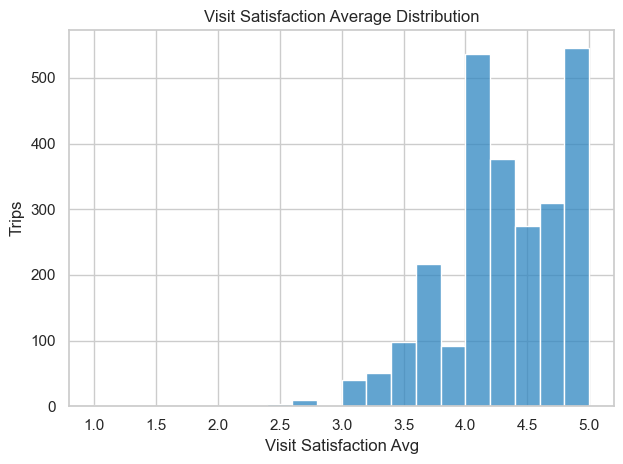

In [32]:
import seaborn as sns

sns.set_theme(style='whitegrid')

if 'TRAVEL_PURPOSE' in prepared_df.columns:
    purpose_series = prepared_df['TRAVEL_PURPOSE'].fillna('UNKNOWN')
    purpose_order = purpose_series.value_counts().head(6).index
    plot_df = prepared_df.copy()
    plot_df['TRAVEL_PURPOSE'] = purpose_series
    ax = sns.countplot(data=plot_df, x='TRAVEL_PURPOSE', order=purpose_order)
    ax.set_title('Top Travel Purpose Frequency')
    ax.set_xlabel('Travel Purpose')
    ax.set_ylabel('Trips')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.figure.tight_layout()

if 'visit_dgstfn_avg' in prepared_df.columns:
    ax2 = sns.histplot(data=prepared_df, x='visit_dgstfn_avg', bins=20, color='#2E86C1')
    ax2.set_title('Visit Satisfaction Average Distribution')
    ax2.set_xlabel('Visit Satisfaction Avg')
    ax2.set_ylabel('Trips')
    ax2.figure.tight_layout()
